In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# PEFT IMDB Imbalance + Noise

This experiment asks whether imbalance in datasets has an impact on robustness of transformer models

In [5]:
import glob
import re

LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 10
limit = 10000
l2 =0.01
method="lora"
LM = "roberta-large"

root_dir = f"../experiments/acl-exp5-{LM}-fixed-method-{method}-limit-{limit}-l2-{l2}-balance-{BALANCE}"

DATASET = f"IMDB-balance-{BALANCE}"

def get_pred_df(root_dir):


    dfs = []
    # for directory in root_dir:
    directory = root_dir
    
    seed = directory.split("-")[-1]
    exp0_subdirs = [f for f in os.listdir(directory)]
    exp0_subdirs
    

    # Use regex to extract the value after "sentiment-"

    # Check if there is a match

    for split in ["train", "val"]:
        for dir in exp0_subdirs:
            # print(dir)
            
            match = re.search(f'{LABEL}-noise-(\d+\.\d+)', dir)
            if match:
                noise_ratio = float(match.group(1))
                # print("Sentiment Value:", noise_ratio)
            else:
                print("No sentiment value found.")

            df = pd.read_csv(os.path.join(root_dir, dir, f"{split}_preds.csv"))
            df["noise_ratio"] = noise_ratio
            df["split"] = split
            df["seed"] = seed
            dfs.append(df)

    pred_df = pd.concat(dfs)
    return pred_df



# F1 Scores

In [6]:
from sklearn.metrics import f1_score,recall_score, precision_score

def get_f1_df(pred_df, epochs=20):

    epochs = []
    f1s = []
    noises = []
    splits = []
    for i in range(0, 20):
        for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:
            for split in ["train", "val"]:
                epochs.append(i)
                noises.append(noise)
                splits.append(split)
                if i == 0:
                    f1s.append(0)
                else:
                    df = pred_df[pred_df["noise_ratio"] == noise]   
                    df = df[df["split"] == split]
                    f1 = f1_score(df["label"], df[f"pred_{i}"], average="binary")
                    f1s.append(f1)
                    # print("noise", noise, "split", split, "epoch", i, "f1", f1)
    
    data = {'epochs': epochs, 'f1s': f1s, "noise":noises, "split":splits}
    df = pd.DataFrame(data) 
    return df






Effect of Balance - Control Data Size

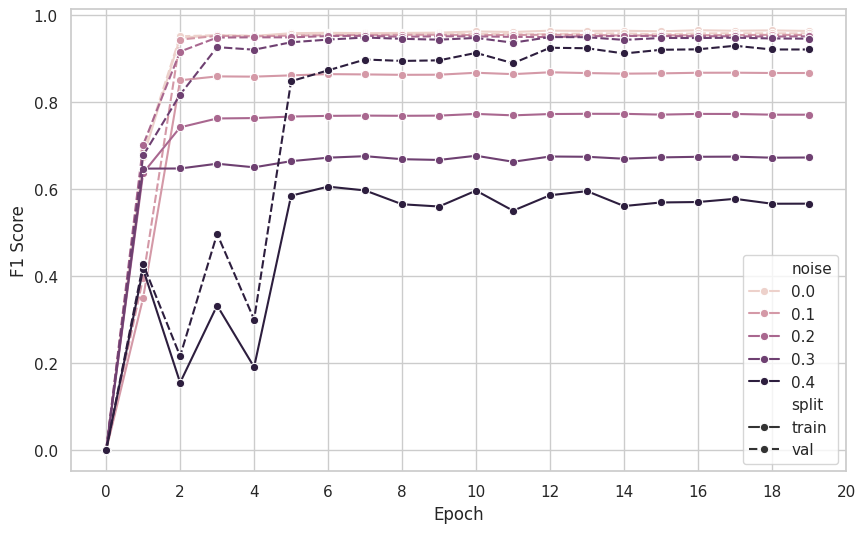

             epochs       f1s
noise split                  
0.0   train      19  0.965090
      val        19  0.958128
0.1   train      19  0.868495
      val        19  0.954781
0.2   train      19  0.773077
      val        19  0.952264
0.3   train      19  0.676721
      val        19  0.949455
0.4   train      19  0.605736
      val        19  0.929438


In [27]:
LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 20
limit = 10000
l2 =0.01
method="lora"
LM = "roberta-large"
max_dfs = []
for balance in [0.5, 0.4, 0.3,0.2,0.1, 0.05, 0.01]:
    if len(LM):
        root_dir = f"../experiments/acl-exp5-fixed-{LM}-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
    else:
        if method == "lora":
            root_dir = f"../experiments/acl-exp5-fixed-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
        else:
            root_dir = f"../experiments/acl-exp5-method-lora-limit-{limit}-l2-{l2}-balance-{balance}"
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    f1_df = get_f1_df(pred_df, epochs=EPOCHS)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

    # Set plot title and labels
    # plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {LABEL}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(loc='best')
    plt.xticks(range(0, EPOCHS+1, 2))
    # plt.savefig(f"{LM}_lora_learning.png", dpi=300, bbox_inches="tight")
    

    # Show the plot
    plt.show()
    max_df = f1_df.groupby([ "noise", "split"]).max()
    
    print(max_df)
    max_df.to_csv("lora-roberta-base-df.csv")
    break

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # You can choose different styles of plots depending on your preference
    sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
    plt.ylim(0.6, 1.2)
    plt.title('F1 Score vs Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel('F1 Score')
    plt.legend(title='Split', loc='lower right')


# 

Experimenting with balance = 5, limits 500,400,300,200,100

In [28]:
max_df.reset_index(inplace=True)
max_df


,noise,split,epochs,f1s
0,0.0,train,19,0.965090
1,0.0,val,19,0.958128
2,0.1,train,19,0.868495
3,0.1,val,19,0.954781
4,0.2,train,19,0.773077
5,0.2,val,19,0.952264
6,0.3,train,19,0.676721
7,0.3,val,19,0.949455
8,0.4,train,19,0.605736
9,0.4,val,19,0.929438


In [29]:
from tabulate import tabulate
latex_table = tabulate(max_df, headers='keys', tablefmt='latex', showindex=False, floatfmt=".3f")
print(latex_table)


\begin{tabular}{rlrr}
\hline
   noise & split   &   epochs &   f1s \\
\hline
   0.000 & train   &       19 & 0.965 \\
   0.000 & val     &       19 & 0.958 \\
   0.100 & train   &       19 & 0.868 \\
   0.100 & val     &       19 & 0.955 \\
   0.200 & train   &       19 & 0.773 \\
   0.200 & val     &       19 & 0.952 \\
   0.300 & train   &       19 & 0.677 \\
   0.300 & val     &       19 & 0.949 \\
   0.400 & train   &       19 & 0.606 \\
   0.400 & val     &       19 & 0.929 \\
\hline
\end{tabular}


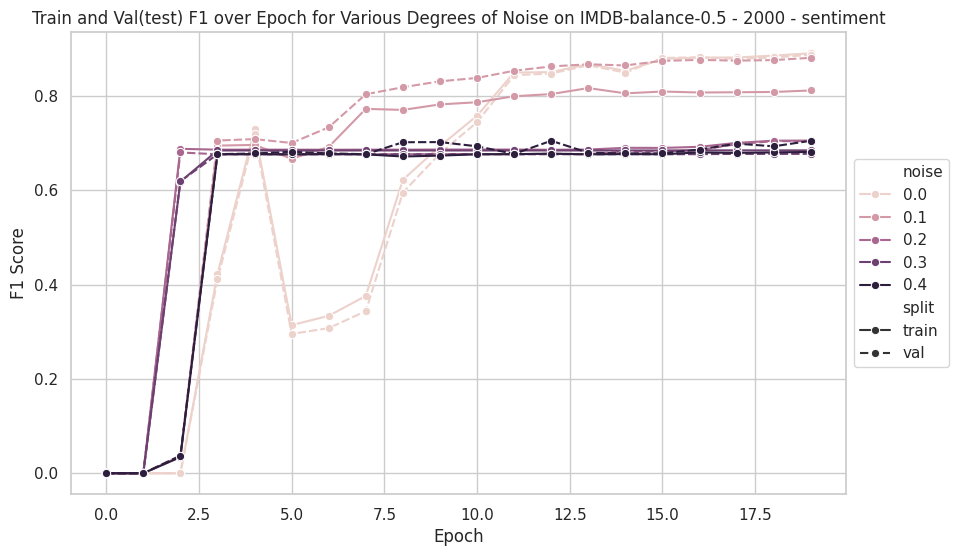

             epochs       f1s
noise split                  
0.0   train      19  0.890862
      val        19  0.887407
0.1   train      19  0.816993
      val        19  0.881143
0.2   train      19  0.705680
      val        19  0.704439
0.3   train      19  0.684868
      val        19  0.677489
0.4   train      19  0.681502
      val        19  0.705259


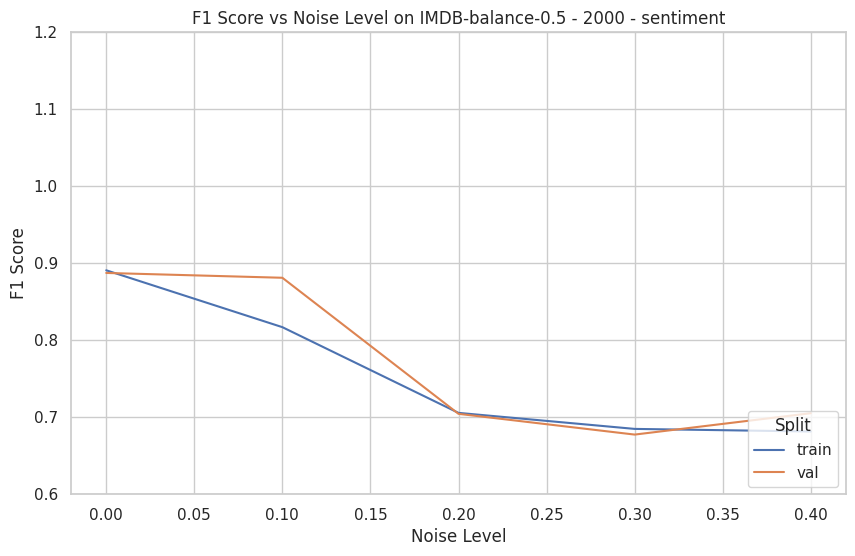

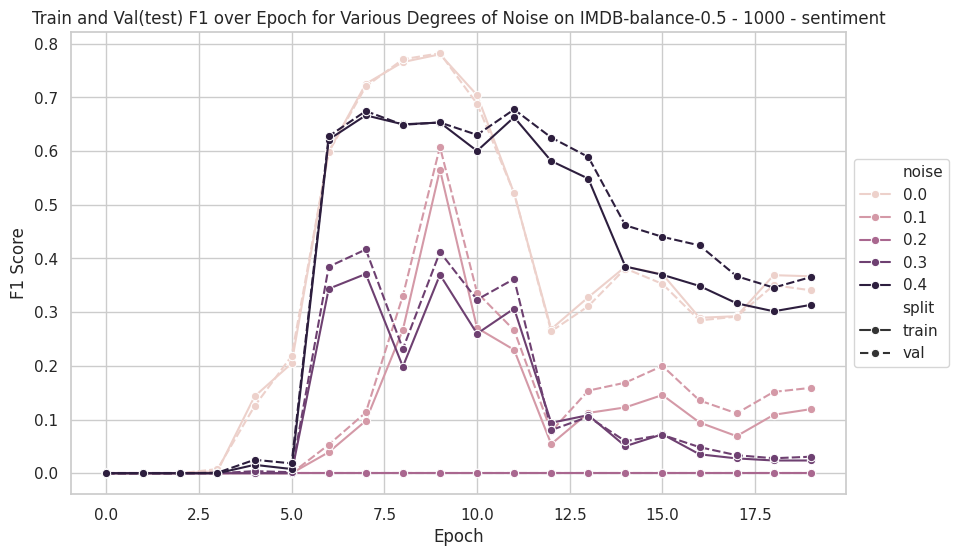

             epochs       f1s
noise split                  
0.0   train      19  0.780362
      val        19  0.782294
0.1   train      19  0.565327
      val        19  0.607880
0.2   train      19  0.000000
      val        19  0.000000
0.3   train      19  0.371223
      val        19  0.416816
0.4   train      19  0.666667
      val        19  0.677594


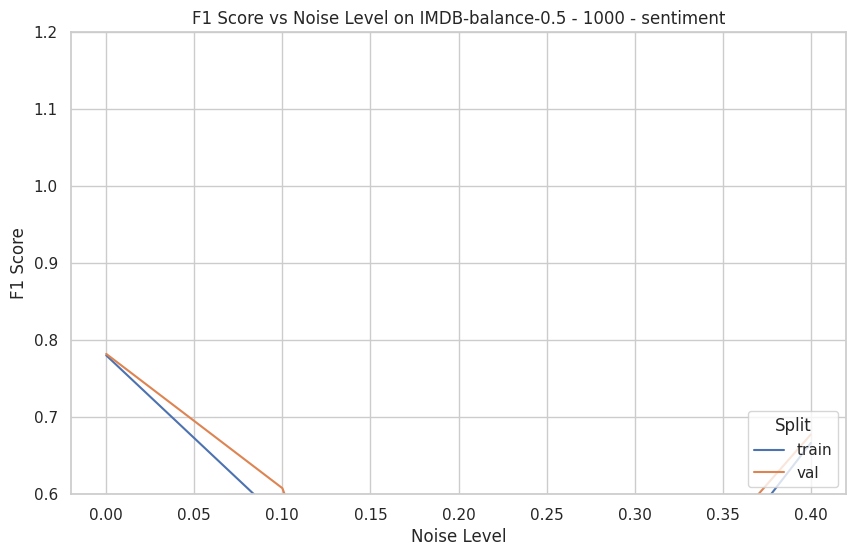

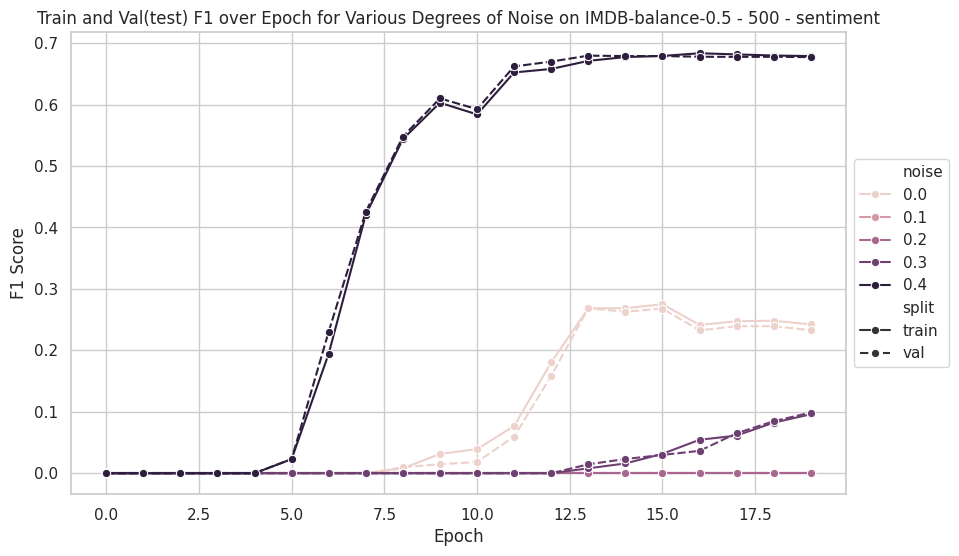

             epochs       f1s
noise split                  
0.0   train      19  0.275168
      val        19  0.268395
0.1   train      19  0.000000
      val        19  0.000000
0.2   train      19  0.000000
      val        19  0.000000
0.3   train      19  0.095941
      val        19  0.098754
0.4   train      19  0.683578
      val        19  0.679681


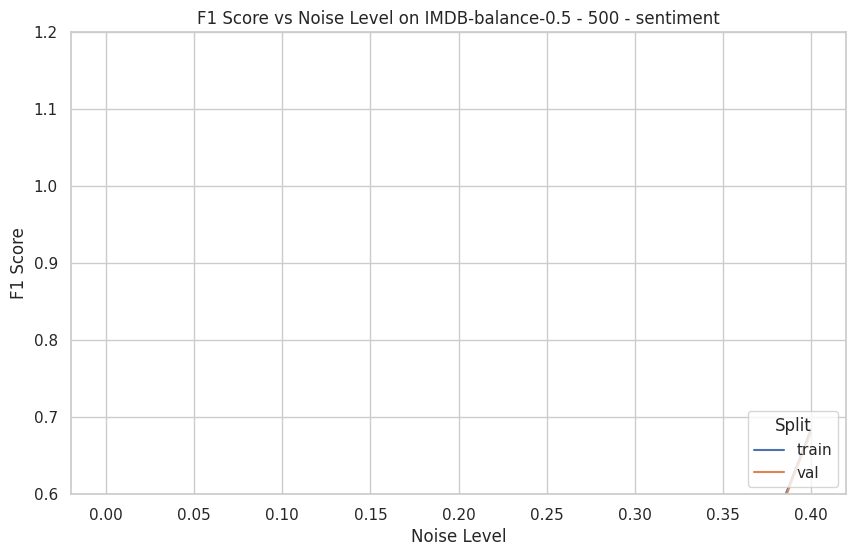

In [9]:
LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 10
limit = 10000
l2 =0.01
method="lora"
balance = 0.5
for limit in [2000,1000, 500]:#, 400, 300, 200, 100]:
    root_dir = f"../experiments/acl-exp6-fixed-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    f1_df = get_f1_df(pred_df, epochs=EPOCHS)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

    # Set plot title and labels
    plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Show the plot
    plt.show()
    max_df = f1_df.groupby([ "noise", "split"]).max()

    print(max_df)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # You can choose different styles of plots depending on your preference
    sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
    plt.ylim(0.6, 1.2)
    plt.title(f'F1 Score vs Noise Level on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Noise Level')
    plt.ylabel('F1 Score')
    plt.legend(title='Split', loc='lower right')


# 

is 100/1000 or 60/100 enough?

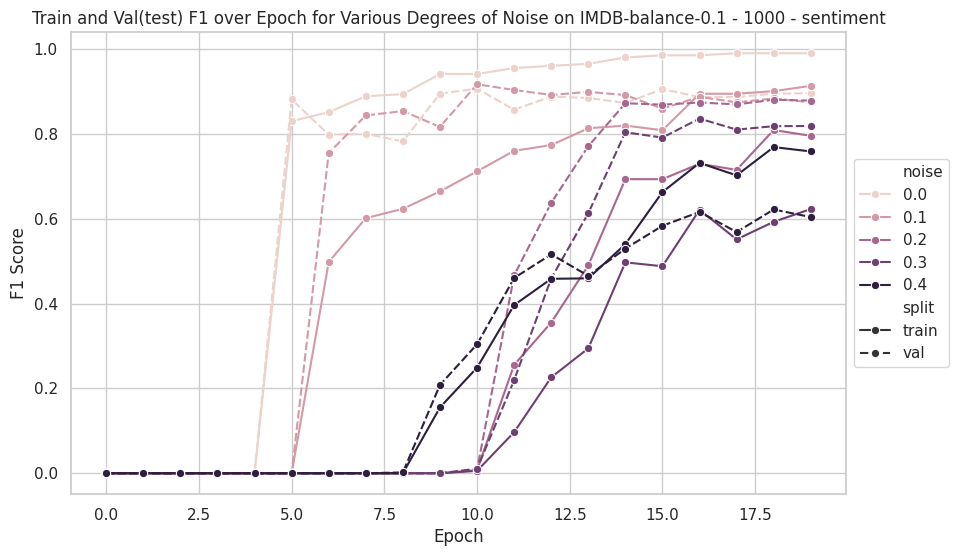

             epochs       f1s
noise split                  
0.0   train      19  0.990099
      val        19  0.906694
0.1   train      19  0.913165
      val        19  0.916955
0.2   train      19  0.809160
      val        19  0.880578
0.3   train      19  0.622776
      val        19  0.836066
0.4   train      19  0.768844
      val        19  0.621800


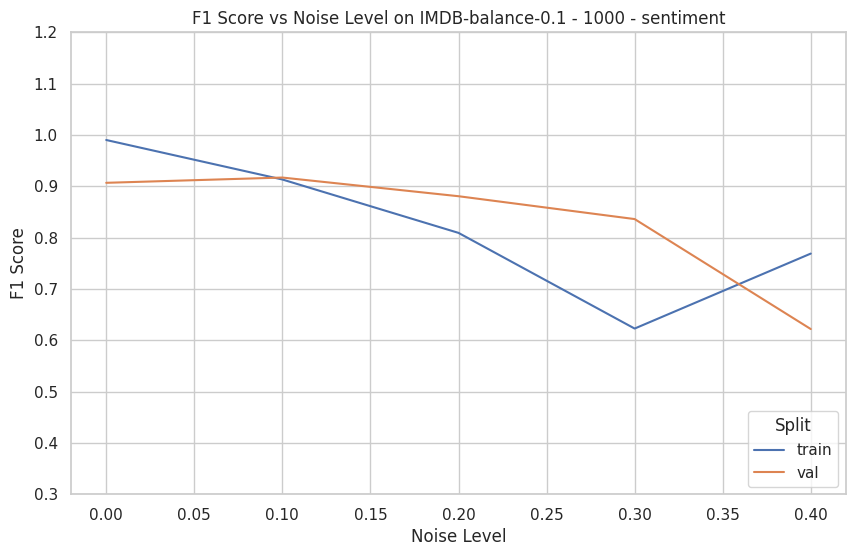

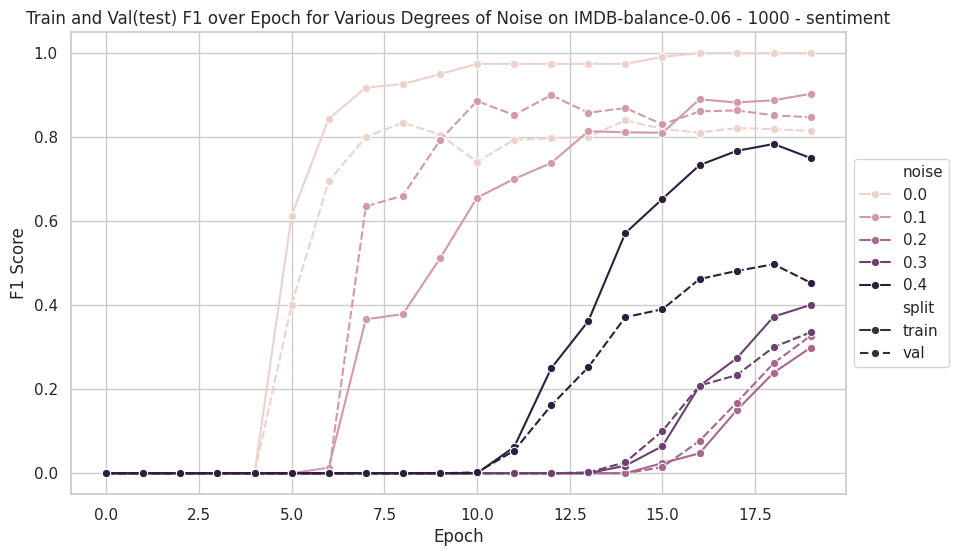

             epochs       f1s
noise split                  
0.0   train      19  1.000000
      val        19  0.840256
0.1   train      19  0.903448
      val        19  0.900295
0.2   train      19  0.299320
      val        19  0.327642
0.3   train      19  0.400901
      val        19  0.335750
0.4   train      19  0.783981
      val        19  0.497605


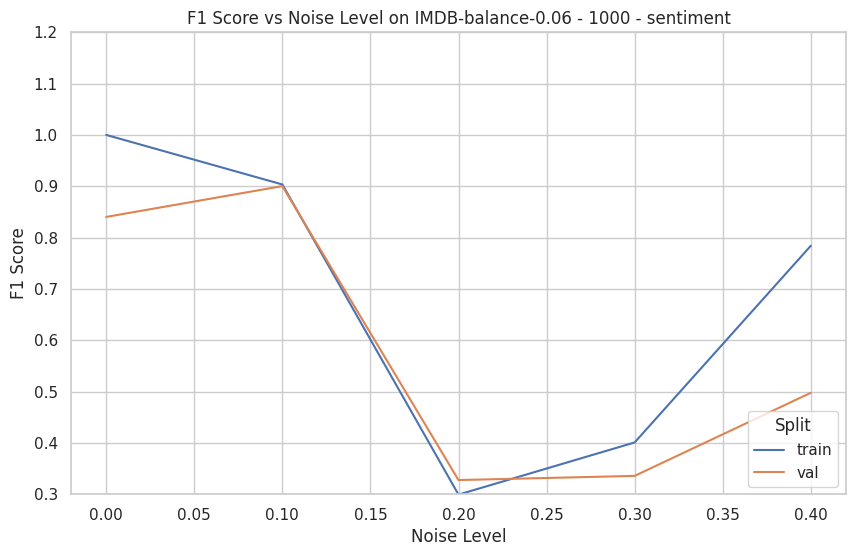

In [7]:
LABEL = "sentiment"
EPOCHS = 20
limit = 1000
l2 =0.01
method="lora"

for balance in [0.1, 0.06]:
    root_dir = f"../experiments/acl-exp6-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    f1_df = get_f1_df(pred_df, epochs=EPOCHS)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

    # Set plot title and labels
    plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Show the plot
    plt.show()
    max_df = f1_df.groupby([ "noise", "split"]).max()

    print(max_df)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # You can choose different styles of plots depending on your preference
    sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
    plt.ylim(0.3, 1.2)
    plt.title(f'F1 Score vs Noise Level on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Noise Level')
    plt.ylabel('F1 Score')
    plt.legend(title='Split', loc='lower right')


# 

what about 60/1000?


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {'epochs': epochs, 'f1s': f1s, "noise":noises, "split":splits}
df = pd.DataFrame(data)
# line_plot(df, "epochs", "f1s", "epochs", "f1s", "F1 through epochs")
df

,epochs,f1s,noise,split
0,0,0.000000,0.0,train
1,0,0.000000,0.0,val
2,0,0.000000,0.1,train
3,0,0.000000,0.1,val
4,0,0.000000,0.2,train
...,...,...,...,...
195,19,0.852114,0.2,val
196,19,0.955461,0.3,train
197,19,0.731521,0.3,val
198,19,0.991925,0.4,train


In [37]:
df.groupby([ "noise", "split"]).max()

epochs       f1s
noise split                  
0.0   train      19  0.999800
      val        19  0.948661
0.1   train      19  0.990570
      val        19  0.939194
0.2   train      19  0.965083
      val        19  0.936379
0.3   train      19  0.955461
      val        19  0.934224
0.4   train      19  0.991925
      val        19  0.892502

In [143]:

plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=df, marker='o')

# Set plot title and labels
plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {LABEL}')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Show the plot
plt.show()

ValueError: Could not interpret value `f1s` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# Learned

Are the noisy data learned?

In [175]:
LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 20
limit = 10000
l2 =0.01
method="lora"
dfs  = []
LM = "roberta-large"
for balance in [0.5, 0.4, 0.3,0.2,0.1, 0.05, 0.01]:
    root_dir = f"../experiments/acl-exp5-fixed-{LM}-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    pred_df["balance"] = balance
    dfs.append(pred_df)
    # break
    # f1_df = get_f1_df(pred_df, epochs=EPOCHS)

pred_dfs = pd.concat(dfs)

In [176]:
pred_df = pred_dfs[pred_dfs["balance"]==0.5]
# bal_df = bal_df[bal_df["split"]=="train"]
# bal_df


,clean_corrects,noise,epoch,total_clean,total_noisy,noisy_corrects,clean_correct_ratio,noisy_correct_ratio,correct_clean_to_total_ratio
40,5394,0.2,1,8014,1986,637,0.673072,0.320745,0.894379
41,7322,0.2,2,8014,1986,184,0.913651,0.092649,0.975486
42,7560,0.2,3,8014,1986,104,0.943349,0.052367,0.986430
43,7580,0.2,4,8014,1986,99,0.945845,0.049849,0.987108
44,7593,0.2,5,8014,1986,98,0.947467,0.049345,0.987258
45,7621,0.2,6,8014,1986,99,0.950961,0.049849,0.987176
46,7613,0.2,7,8014,1986,101,0.949963,0.050856,0.986907
47,7613,0.2,8,8014,1986,108,0.949963,0.054381,0.986012
48,7623,0.2,9,8014,1986,105,0.951210,0.052870,0.986413
49,7629,0.2,10,8014,1986,106,0.951959,0.053374,0.986296


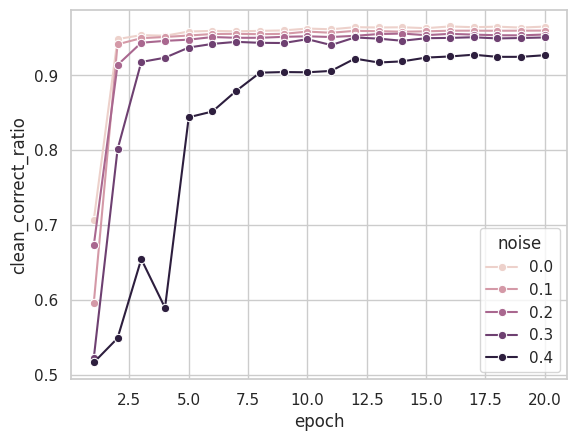

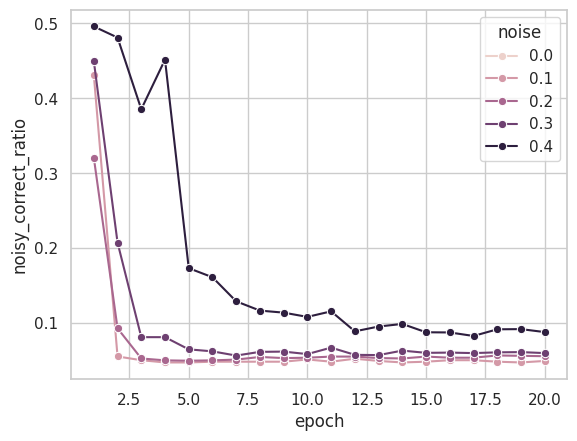

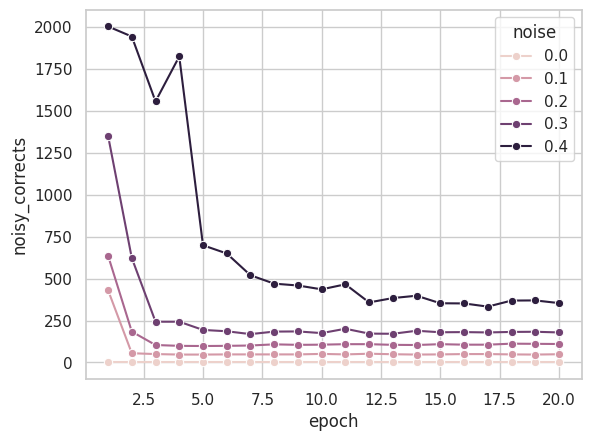

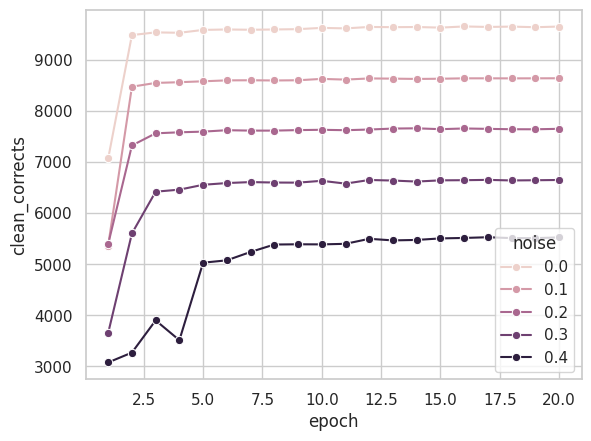

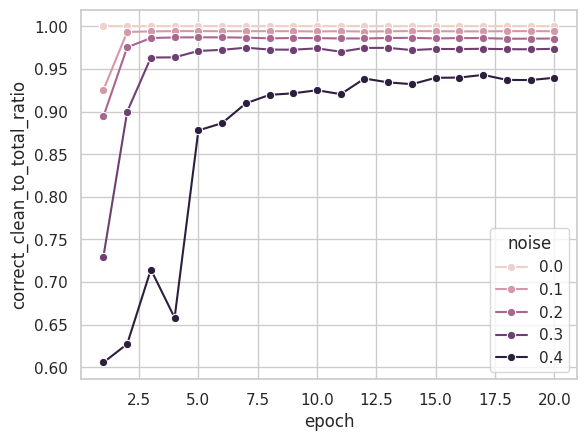

In [177]:
clean_corrects = []
noises = []
epochs = []
total_clean = []
total_noisy = []
noisy_corrects =[]
for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:
    for split in ["train"]:
        for i in range(1,EPOCHS+1):
            noises.append(noise)
            epochs.append(i)
            df = pred_df[pred_df["noise_ratio"] == noise]   
            split_df = df[df["split"] == split]
            clean_corrects.append(len((split_df[(split_df[f"pred_{i}"] == split_df["label"]) & (split_df["label_flipped"]==False)])))
            noisy_corrects.append(len((split_df[(split_df[f"pred_{i}"] == split_df["label"]) & (split_df["label_flipped"]==True)])))
            total_clean.append(len((split_df[(split_df["label_flipped"]==False)])))
            total_noisy.append(len((split_df[(split_df["label_flipped"]==True)])))

df = pd.DataFrame({"clean_corrects":clean_corrects, "noise":noises, "epoch":epochs, "total_clean":total_clean, "total_noisy":total_noisy, "noisy_corrects":noisy_corrects})
df["clean_correct_ratio"]=df["clean_corrects"]/df["total_clean"]
df["noisy_correct_ratio"]=df["noisy_corrects"]/df["total_noisy"]
sns.lineplot(x='epoch', y='clean_correct_ratio', hue='noise', data=df, marker='o')
plt.figure()
sns.lineplot(x='epoch', y='noisy_correct_ratio', hue='noise', data=df, marker='o')
plt.figure()
sns.lineplot(x='epoch', y='noisy_corrects', hue='noise', data=df, marker='o')
plt.figure()
sns.lineplot(x='epoch', y='clean_corrects', hue='noise', data=df, marker='o')
            
df["correct_clean_to_total_ratio"] = df["clean_corrects"]/(df["noisy_corrects"]+ df["clean_corrects"])
plt.figure()
sns.lineplot(x='epoch', y='correct_clean_to_total_ratio', hue='noise', data=df, marker='o')

df[df.noise==0.2]

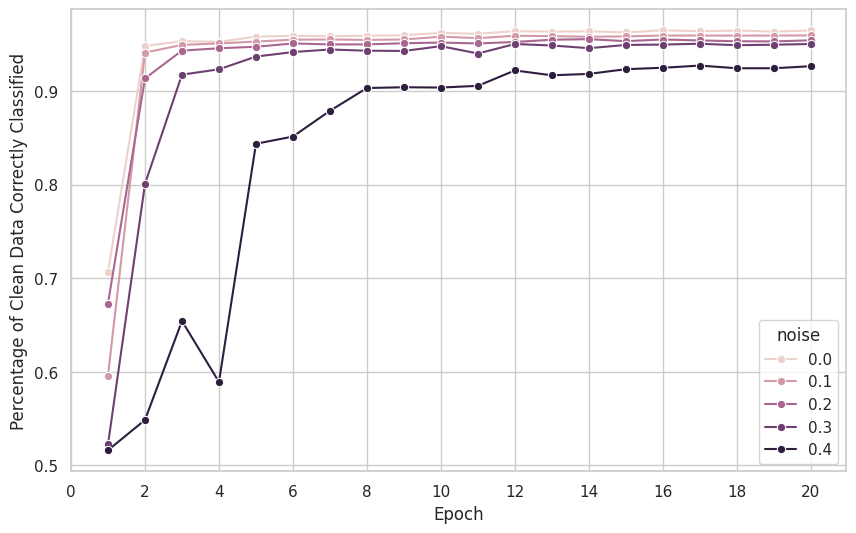

In [178]:

plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='clean_correct_ratio', hue='noise', data=df, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Percentage of Clean Data Correctly Classified')
plt.xticks(range(0, df['epoch'].max()+1, 2))
plt.savefig(f"{LM}_clean_training_accuracy_plot.png", dpi=300, bbox_inches='tight')

# sns.lineplot(x='epoch', y='noisy_correct_ratio', hue='noise', data=df, marker='o')
# plt.figure()
# sns.lineplot(x='epoch', y='noisy_corrects', hue='noise', data=df, marker='o')
# plt.figure()
# sns.lineplot(x='epoch', y='clean_corrects', hue='noise', data=df, marker='o')


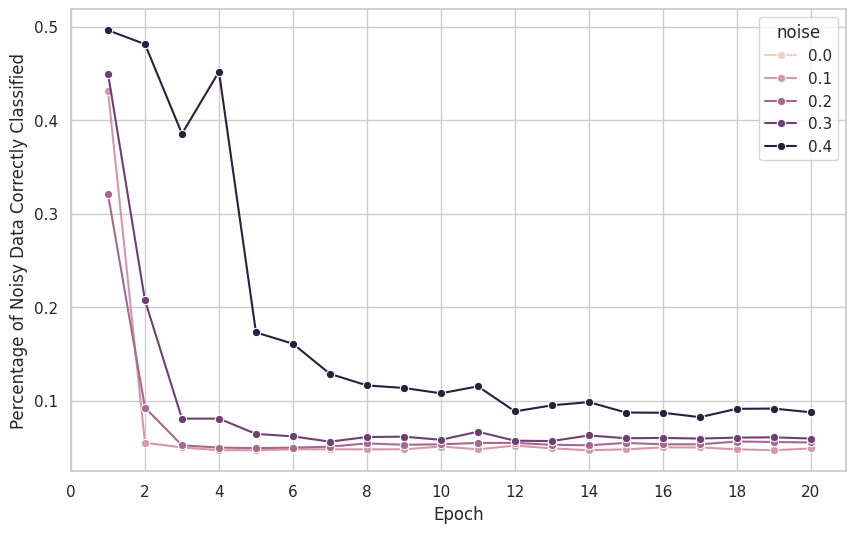

In [179]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='noisy_correct_ratio', hue='noise', data=df, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Percentage of Noisy Data Correctly Classified')
plt.xticks(range(0, df['epoch'].max()+1, 2))
plt.savefig(f"{LM}_noisy_training_accuracy_plot.png", dpi=300, bbox_inches='tight')

In [180]:
cur_clean_correct = (split_df[(split_df[f"pred_{i}"] == split_df["label"]) & (split_df["label_flipped"]==False)])
cur_clean = split_df["label_flipped"]==False
cur_clean

0        True
1       False
2        True
3        True
4        True
        ...  
9995     True
9996     True
9997    False
9998    False
9999    False
Name: label_flipped, Length: 10000, dtype: bool

In [181]:
cur_clean_correct

,id,label_flipped,label,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,...,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,noise_ratio,split,seed,balance
0,13559,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.4,train,0.5,0.5
2,24874,False,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.4,train,0.5,0.5
3,29759,False,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.4,train,0.5,0.5
4,1229,False,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.4,train,0.5,0.5
8,9397,False,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.4,train,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,14329,False,1,1,0,0,0,1,1,1,...,1,1,1,1,1,1,0.4,train,0.5,0.5
9992,32331,False,1,1,0,0,0,1,1,1,...,1,1,1,1,1,1,0.4,train,0.5,0.5
9993,1468,False,1,0,0,0,0,1,1,1,...,1,1,1,1,1,1,0.4,train,0.5,0.5
9995,28438,False,1,0,0,0,0,1,1,1,...,1,1,1,1,1,1,0.4,train,0.5,0.5


In [182]:
epochs = []
learned_so_far = []
learned_this_epoch = []
forgotten_this_epoch = []
forgotten_so_far = []
curr_noisy_corrects = []
curr_clean_corrects = []
splits = []
noise_ratios = []
for split in ["train", "val"]:
    for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:

        split_df = pred_df[(pred_df["split"] == split) & (pred_df["noise_ratio"] == noise)]
        total_learned = [False]*len(split_df)
        total_forgotten = [False]*len(split_df)

        for i in range(1, EPOCHS+1):
            epochs.append(i)
            splits.append(split)
            noise_ratios.append(noise)
            cur_learned = list(split_df[f"pred_{i}"] == split_df["label"])
            cur_clean_correct = (split_df[(split_df[f"pred_{i}"] == split_df["label"]) & (split_df["label_flipped"]==False)])
            cur_noisy_correct = (split_df[(split_df[f"pred_{i}"] == split_df["label"]) & (split_df["label_flipped"]==True)])
            curr_clean_corrects.append(len(cur_clean_correct))
            curr_noisy_corrects.append(len(cur_noisy_correct))
            total_learned = [x or y for x, y in zip(total_learned, cur_learned)]
            learned_so_far.append(sum(total_learned))
            if i == 1:
                learned_this_epoch.append(sum(cur_learned))
                forgotten_this_epoch.append(0)
                forgotten_so_far.append(0)
            else:
                learned_this_epoch.append(learned_so_far[-1] - learned_so_far[-2])
                cur_forgotten = list((split_df[f"pred_{i-1}"] == split_df["label"]) & (split_df[f"pred_{i}"] != split_df["label"]))
                forgotten_this_epoch.append(sum(cur_forgotten))
                total_forgotten = [x or y for x, y in zip(total_forgotten, cur_forgotten)]
                forgotten_so_far.append(sum(total_forgotten))
        


# df = pd.DataFrame({'epochs': epochs, 'learned': learned_so_far})
# line_plot(df, "epochs", "learned", "epochs", "total learned so far", "Number of Total Learned (incl forgotten) through epochs")

# df = pd.DataFrame({'epochs': epochs, 'learned_this_epoch': learned_this_epoch})
# line_plot(df, "epochs", "learned_this_epoch", "epochs", "learned_this_epoch", "Number of  newly Learned through epochs")

# df = pd.DataFrame({'epochs': epochs, 'forgotten_this_epoch': forgotten_this_epoch})
# line_plot(df, "epochs", "forgotten_this_epoch", "epochs", "forgotten_this_epoch", "Number of  newly forgotten through epochs")

# print("total learned =", sum(total_learned)/len(pred_df), "\t total_forgotten =", sum(total_forgotten)/len(pred_df))

In [183]:
df = pd.DataFrame({"noise":noise_ratios, 'epochs': epochs, 'forgotten_so_far':forgotten_so_far, 'learned_so_far': learned_so_far, 'learned_this_epoch': learned_this_epoch, 'forgotten_this_epoch': forgotten_this_epoch, "split":splits, "cur_clean_correct":curr_noisy_corrects, "cur_noisy_correct":curr_noisy_corrects})
df

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split,cur_clean_correct,cur_noisy_correct
0,0.0,1,0,7068,7068,0,train,0,0
1,0.0,2,206,9688,2620,206,train,0,0
2,0.0,3,227,9734,46,21,train,0,0
3,0.0,4,276,9758,24,52,train,0,0
4,0.0,5,303,9782,24,38,train,0,0
...,...,...,...,...,...,...,...,...,...
195,0.4,16,1553,3952,0,10,val,0,0
196,0.4,17,1553,3952,0,25,val,0,0
197,0.4,18,1554,3952,0,67,val,0,0
198,0.4,19,1554,3952,0,6,val,0,0


In [184]:
df[df["epochs"]==20]

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split,cur_clean_correct,cur_noisy_correct
19,0.0,20,364,9832,0,2,train,0,0
39,0.1,20,803,9311,0,8,train,49,49
59,0.2,20,1108,8604,0,10,train,110,110
79,0.3,20,2265,8538,0,18,train,179,179
99,0.4,20,5073,8809,0,43,train,354,354
119,0.0,20,151,3929,0,2,val,0,0
139,0.1,20,151,3914,0,4,val,0,0
159,0.2,20,225,3933,0,3,val,0,0
179,0.3,20,467,3953,0,5,val,0,0
199,0.4,20,1554,3952,0,14,val,0,0


In [185]:
total_train = len(pred_df[(pred_df["split"] == "train") & (pred_df["noise_ratio"] == 0.0)])
total_val = len(pred_df[(pred_df["split"] == "val") & (pred_df["noise_ratio"] == 0.0)])

In [186]:
df

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split,cur_clean_correct,cur_noisy_correct
0,0.0,1,0,7068,7068,0,train,0,0
1,0.0,2,206,9688,2620,206,train,0,0
2,0.0,3,227,9734,46,21,train,0,0
3,0.0,4,276,9758,24,52,train,0,0
4,0.0,5,303,9782,24,38,train,0,0
...,...,...,...,...,...,...,...,...,...
195,0.4,16,1553,3952,0,10,val,0,0
196,0.4,17,1553,3952,0,25,val,0,0
197,0.4,18,1554,3952,0,67,val,0,0
198,0.4,19,1554,3952,0,6,val,0,0


In [187]:
df[(df["epochs"]==10) & (df["split"] == "train") & (df["noise"]==0.2)]["learned_so_far"].values[0]/total_train

N_fs = []
N_ls = []
noises = []
splits = []
for noise in [0.1, 0.2, 0.3, 0.4]:
    for split in ["train", "val"]:
        N_forgotten = df[(df["epochs"]==EPOCHS) & (df["split"] == split)& (df["noise"]==noise)]["forgotten_so_far"].values[0]
        N_learned = df[(df["epochs"]==10) & (df["split"] == split) & (df["noise"]==noise)]["learned_so_far"].values[0]
        print(f"noise {noise} split {split} forgotten {N_forgotten} learned {N_learned} forgotten/learned {N_forgotten/N_learned}")
        N_fs.append(N_forgotten)
        N_ls.append(N_learned)
        noises.append(noise)
        splits.append(split)

learned_df = pd.DataFrame({"noise":noises, "split":splits, "N_forgotten":N_fs, "N_learned":N_ls})


noise 0.1 split train forgotten 803 learned 9302 forgotten/learned 0.08632552139324877
noise 0.1 split val forgotten 151 learned 3912 forgotten/learned 0.03859918200408998
noise 0.2 split train forgotten 1108 learned 8596 forgotten/learned 0.12889716147045138
noise 0.2 split val forgotten 225 learned 3931 forgotten/learned 0.05723734418722971
noise 0.3 split train forgotten 2265 learned 8509 forgotten/learned 0.26618874133270654
noise 0.3 split val forgotten 467 learned 3948 forgotten/learned 0.11828774062816616
noise 0.4 split train forgotten 5073 learned 8786 forgotten/learned 0.5773958570452994
noise 0.4 split val forgotten 1554 learned 3940 forgotten/learned 0.39441624365482236


Text(0.5, 1.0, 'Number of Total forgettable through Epochs on IMDB-balance-0.01 - sentiment')

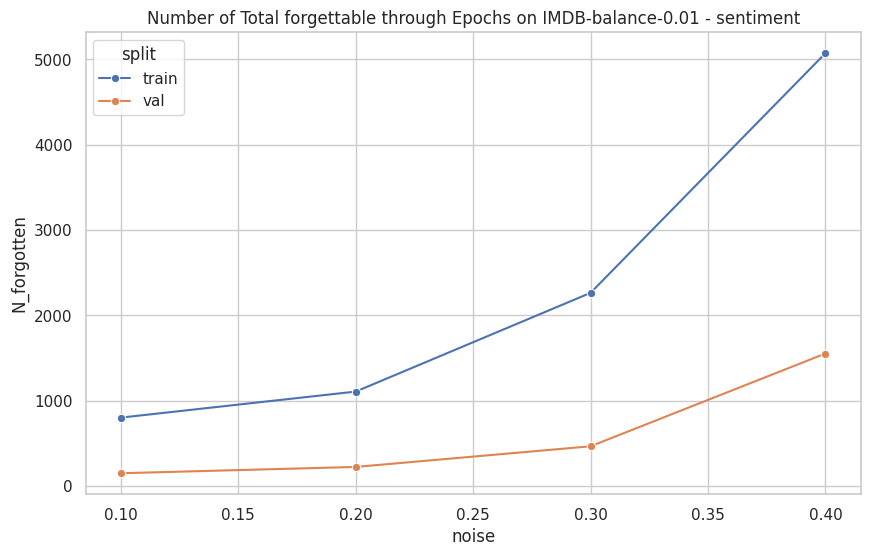

In [188]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='noise', y='N_forgotten', hue='split', data=learned_df, marker='o')
plt.ylabel("Number of Total forgottable")
plt.title(f"Number of Total forgettable through Epochs on {DATASET} - {LABEL}")

In [189]:
df

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split,cur_clean_correct,cur_noisy_correct
0,0.0,1,0,7068,7068,0,train,0,0
1,0.0,2,206,9688,2620,206,train,0,0
2,0.0,3,227,9734,46,21,train,0,0
3,0.0,4,276,9758,24,52,train,0,0
4,0.0,5,303,9782,24,38,train,0,0
...,...,...,...,...,...,...,...,...,...
195,0.4,16,1553,3952,0,10,val,0,0
196,0.4,17,1553,3952,0,25,val,0,0
197,0.4,18,1554,3952,0,67,val,0,0
198,0.4,19,1554,3952,0,6,val,0,0


Text(0.5, 1.0, 'Number of Total Learned (incl forgotten) through Epochs on IMDB-balance-0.01 - sentiment')

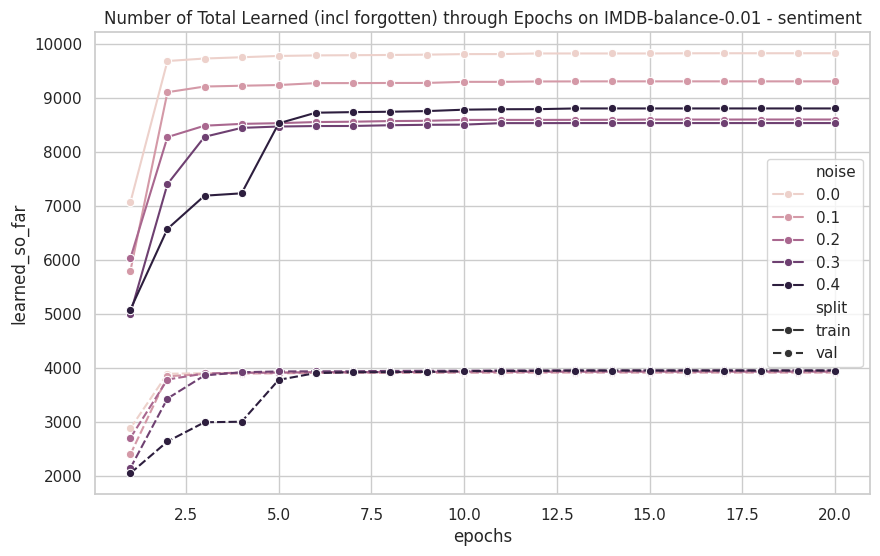

In [190]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epochs", y="learned_so_far", hue="noise", style="split", marker='o')
plt.title(f"Number of Total Learned (incl forgotten) through Epochs on {DATASET} - {LABEL}")

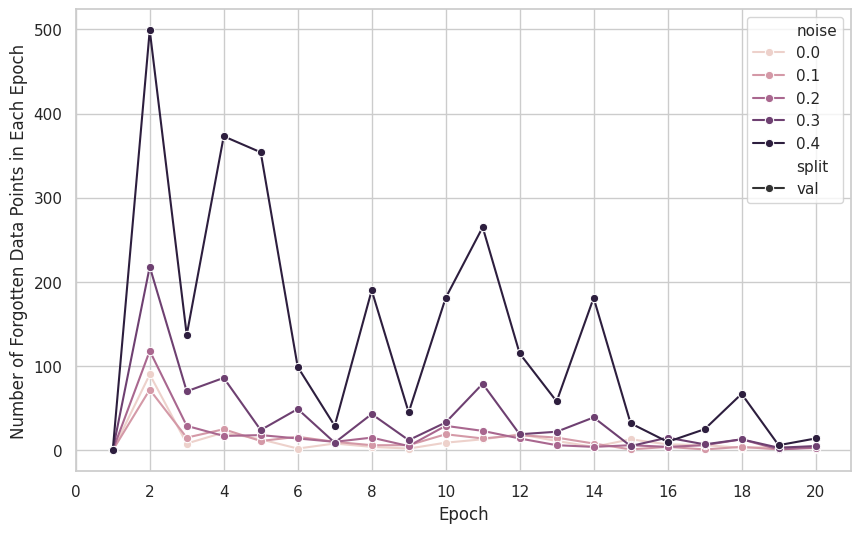

In [191]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df[df.split=="val"], x="epochs", y="forgotten_this_epoch", hue="noise", style="split", marker='o')
# plt.title(f"Number of Forgotten Data Points in Each epoch {DATASET} - {LABEL}")
plt.xticks(range(0, EPOCHS+1, 2))
plt.xlabel('Epoch')
plt.ylabel('Number of Forgotten Data Points in Each Epoch')
plt.savefig(f'{LM}_forgotten_data_each_epoch_plot.png', dpi=300, bbox_inches='tight')

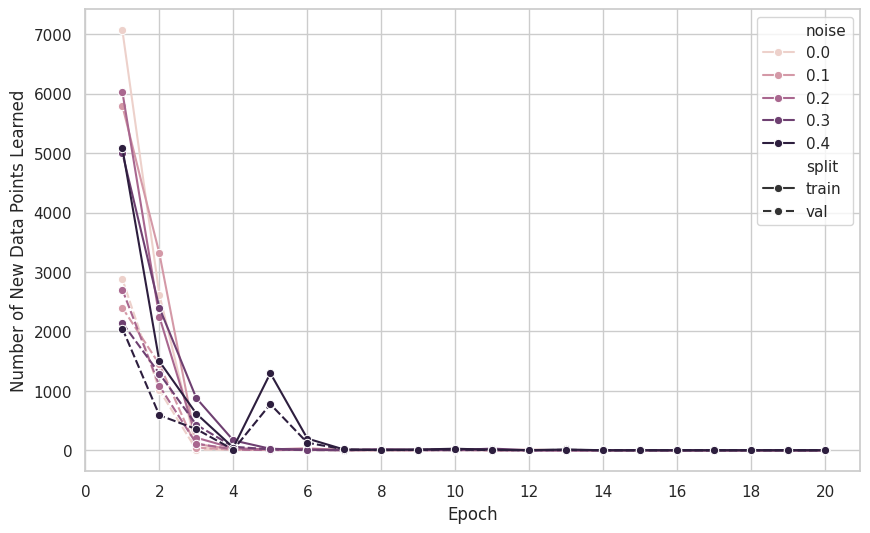

In [192]:
# this counts learning of each data point only once
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epochs", y="learned_this_epoch", hue="noise", style="split", marker='o')
# plt.title("Number of New Data Points Learned in Each epoch")
plt.ylabel("Number of New Data Points Learned")
plt.xticks(range(0, df['epochs'].max()+1, 2))
plt.xlabel('Epoch')
plt.savefig(f'{LM}_newly_learned_data_points_plot.png', dpi=300, bbox_inches='tight')

In [201]:
cur_forgotten

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [202]:
total_learned


[True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,

# Cleaning with LORA

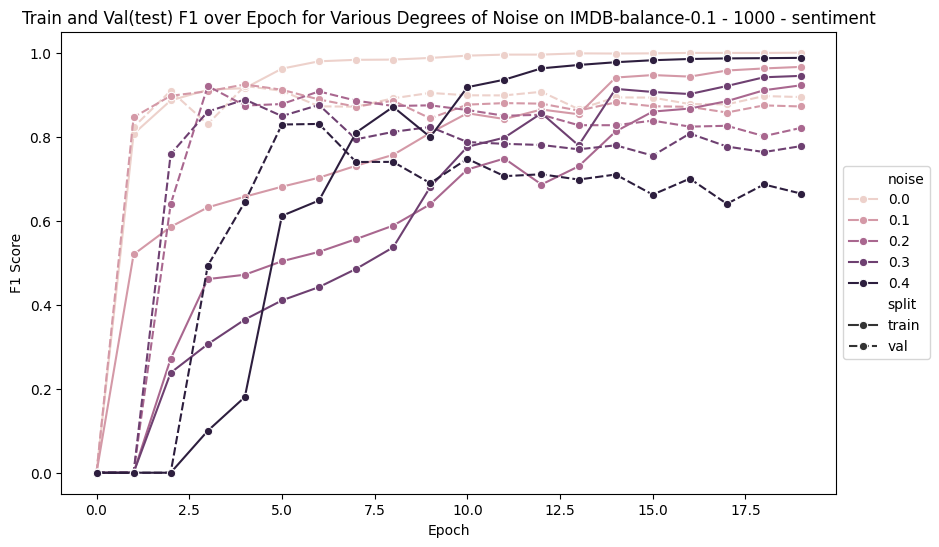

             epochs       f1s
noise split                  
0.0   train      19  0.999500
      val        19  0.920506
0.1   train      19  0.965805
      val        19  0.923971
0.2   train      19  0.922015
      val        19  0.920162
0.3   train      19  0.944403
      val        19  0.888127
0.4   train      19  0.987282
      val        19  0.830043


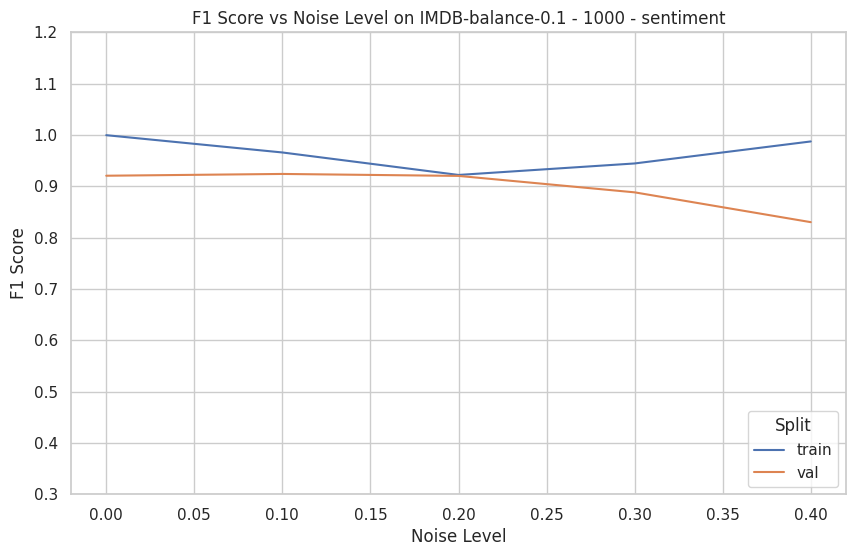

In [7]:
LABEL = "sentiment"
EPOCHS = 10
limit = 1000
l2 =0.01
method="lora"

balance = 0.1
root_dir = f"../experiments/acl-exp5-method-lora-limit-10000-l2-0.01-balance-{balance}"
DATASET = f"IMDB-balance-{balance}"
pred_df = get_pred_df(root_dir)
f1_df = get_f1_df(pred_df, epochs=EPOCHS)
plt.figure(figsize=(10, 6))
sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

# Set plot title and labels
plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {limit} - {LABEL}')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Show the plot
plt.show()
max_df = f1_df.groupby([ "noise", "split"]).max()

print(max_df)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# You can choose different styles of plots depending on your preference
sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
plt.ylim(0.3, 1.2)
plt.title(f'F1 Score vs Noise Level on {DATASET} - {limit} - {LABEL}')
plt.xlabel('Noise Level')
plt.ylabel('F1 Score')
plt.legend(title='Split', loc='lower right')


# 

In [ ]:
LABEL = "sentiment"
EPOCHS = 10
limit = 1000
l2 =0.01
method="lora"

balance = 0.1
root_dir = f"../experiments/acl-exp5-method-lora-limit-10000-l2-0.01-balance-{balance}"
DATASET = f"IMDB-balance-{balance}"
pred_df = get_pred_df(root_dir)
f1_df = get_f1_df(pred_df, epochs=EPOCHS)
plt.figure(figsize=(10, 6))
sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

# Set plot title and labels
plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {limit} - {LABEL}')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Show the plot
plt.show()
max_df = f1_df.groupby([ "noise", "split"]).max()

print(max_df)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# You can choose different styles of plots depending on your preference
sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
plt.ylim(0.3, 1.2)
plt.title(f'F1 Score vs Noise Level on {DATASET} - {limit} - {LABEL}')
plt.xlabel('Noise Level')
plt.ylabel('F1 Score')
plt.legend(title='Split', loc='lower right')


# 

In [18]:
from sklearn.metrics import f1_score,recall_score, precision_score

# dfs = []
# df = pd.read_csv("./temp_dir/train_preds.csv")
# df["split"] = "train"
# dfs.append(df)
df = pd.read_csv("./temp_dir/val_preds.csv")
df["split"] = "val"
for i in range(1,6):
    f1 = f1_score(df["label"], df[f"pred_{i}"], average="binary")
    print(f"{i}: {f1}")

# dfs.append(df)
# df = pd.concat(dfs)
# epochs = []
# f1s = []
# noises = []
# splits = []
# for i in range(0, 5):
#     for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:
#         for split in ["train", "val"]:
#             epochs.append(i)
#             noises.append(noise)
#             splits.append(split)
#             if i == 0:
#                 f1s.append(0)
#             else:
#                 # df = pred_df[pred_df["noise_ratio"] == noise]   
#                 df = df[df["split"] == split]
#                 f1 = f1_score(df["label"], df[f"pred_{i}"], average="binary")
#                 f1s.append(f1)
#                 # print("noise", noise, "split", split, "epoch", i, "f1", f1)

# data = {'epochs': epochs, 'f1s': f1s, "noise":noises, "split":splits}
# res_df = pd.DataFrame(data) 







1: 0.8934740882917466
2: 0.9103072348860257
3: 0.9137721641972311
4: 0.8569868995633187
5: 0.877127659574468


In [14]:
res_df

,epochs,f1s,noise,split
0,0,0.000000,0.0,train
1,0,0.000000,0.0,val
2,0,0.000000,0.1,train
3,0,0.000000,0.1,val
4,0,0.000000,0.2,train
5,0,0.000000,0.2,val
6,0,0.000000,0.3,train
7,0,0.000000,0.3,val
8,0,0.000000,0.4,train
9,0,0.000000,0.4,val
